# Plot number of virus types per primer type

In [1]:
bp = "PRJNA820450"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}"
u_tax_tsv = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_noduplicates.tsv"

In [2]:
import numpy as np
from scipy import stats
import anndata
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

In [3]:
palmdb_adata = anndata.read(f"{fastq_folder}/virus/virus_all.h5ad")
palmdb_adata

AnnData object with n_obs × n_vars = 64436 × 296561
    obs: 'srr', 'iden_bc', 'barcode', 'bci', 'uid', 'well', 'type', 'sample', 'well_ID', 'Sample_name', 'title', 'source_name', 'organism', 'APOE_genotype', 'condition', 'host_QC', 'host_leiden'

___

### Add virus type to lookup table

Kingdom Orthornavirae:  
+ssRNA viruses  
-ssRNA viruses  
dsRNA  

Kingdom Pararnavirae:  
ssRNA-RT  
dsDNA-RT

##### Riboviria:  
Pisuviricota (infect eukaryotes): +ssRNA & dsRNA  
 - Pisoniviricetes: +ssRNA
 - Stelpaviricetes: +ssRNA
 - Duplopiviricetes: dsRNA

Negarnaviricota: -ssRNA   
Kitrinoviricota (infect eukaryotes): +ssRNA   
Lenarviricota (infect prokaryotes): +ssRNA   
Duplornaviricota: dsRNA  

Artverviricota: ssRNA-RT & dsDNA-RT  
Nucleocytoviricota: nucleocytoplasmic large DNA viruses (NCLDV)  
  
   
##### Duplodnaviria:  
Peploviricota: dsDNA  
Uroviricota: tailed bacteriophages  

In [4]:
id2tax_df = pd.read_csv(u_tax_tsv, sep='\t')
id2tax_df.head()

,Label,phylum,class,order,family,genus,species
0,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
1,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus
2,u100,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus
3,u1000,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Henipavirus,Hendra henipavirus
4,u10000,Pisuviricota,Pisoniviricetes,Picornavirales,Caliciviridae,Norovirus,Norwalk virus


In [5]:
virus_types = []
for i, phylum in enumerate(id2tax_df["phylum"].values):
    if phylum == "Pisuviricota":
        class_ = id2tax_df.iloc[i]["class"]
        if class_ == "Pisoniviricetes":
            virus_types.append("+ssRNA")
        elif class_ == "Stelpaviricetes":
            virus_types.append("+ssRNA")
        elif class_ == "Duplopiviricetes":
            virus_types.append("dsRNA")
        else:
            virus_types.append("+ssRNA or dsRNA")

    elif phylum == "Negarnaviricota":
        virus_types.append("-ssRNA")

    elif phylum == "Kitrinoviricota":
        virus_types.append("+ssRNA")

    elif phylum == "Lenarviricota":
        virus_types.append("+ssRNA")

    elif phylum == "Duplornaviricota":
        virus_types.append("dsRNA")

    elif phylum == "Artverviricota":
        virus_types.append("ssRNA-RT or dsDNA-RT")

    elif phylum == "Nucleocytoviricota":
        virus_types.append("NCLDV")

    elif phylum == "Peploviricota":
        virus_types.append("dsDNA")

    elif phylum == "Uroviricota":
        virus_types.append("tailed bacteriophage")

    else:
        virus_types.append("unknown")
        
id2tax_df["virus_type"] = virus_types
id2tax_df

,Label,phylum,class,order,family,genus,species,virus_type
0,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
2,u100,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus,+ssRNA
3,u1000,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Henipavirus,Hendra henipavirus,-ssRNA
4,u10000,Pisuviricota,Pisoniviricetes,Picornavirales,Caliciviridae,Norovirus,Norwalk virus,+ssRNA
...,...,...,...,...,...,...,...,...
296556,u99995,.,.,.,.,.,.,unknown
296557,u99996,Lenarviricota,Howeltoviricetes,Cryppavirales,Mitoviridae,.,.,+ssRNA
296558,u99997,.,.,.,.,.,.,unknown
296559,u99998,.,.,.,.,.,.,unknown


___
### Plot total counts per virus type

In [6]:
vtypes = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA or dsRNA']
vlabels = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA\nor dsRNA']

t_counts = []
r_counts = []
for vt in vtypes:
    target_ids = id2tax_df[id2tax_df["virus_type"] == vt]["Label"].values
    
    # Get counts for poly T primer
    tc = palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.sum()
    t_counts.append(tc)
    
    # Get counts for random primers
    rc = palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.sum()
    r_counts.append(rc)

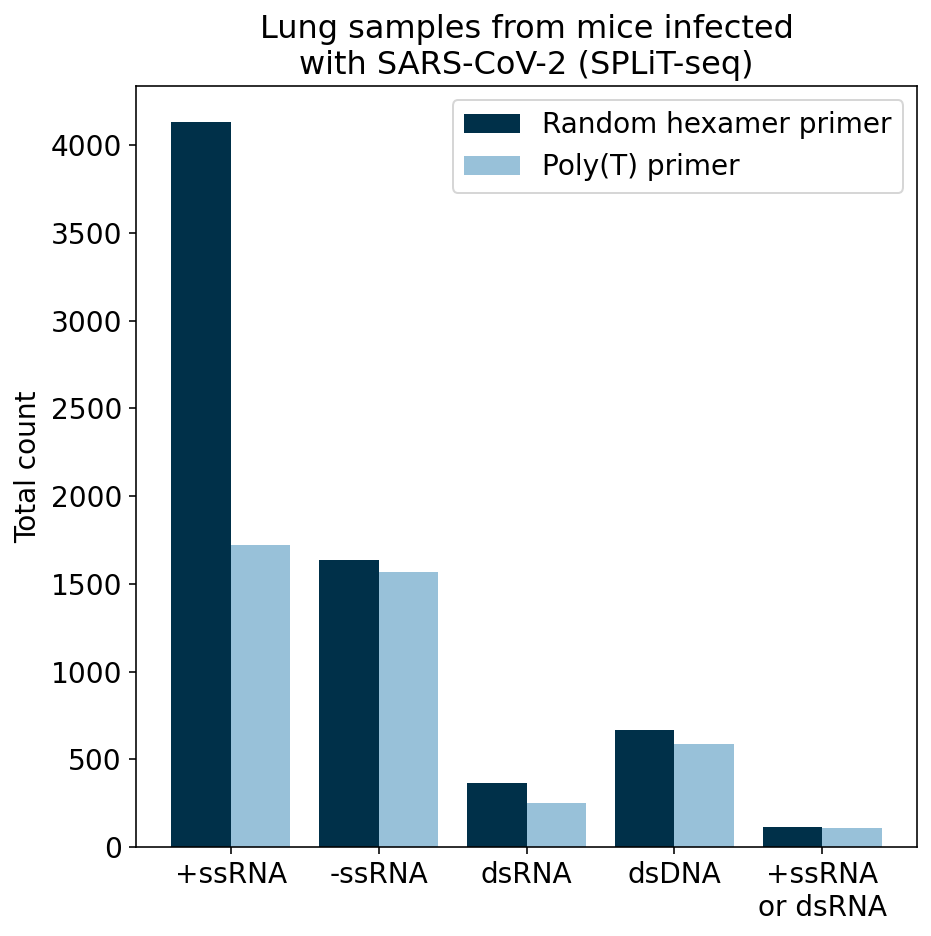

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))

fontsize = 14
width = 0.4
colors = ["#003049", "#98c1d9"]

x = np.arange(len(vtypes))
ax.bar(x-width/2, r_counts, width=width, color=colors[0], label="Random hexamer primer")
ax.bar(x+width/2, t_counts, width=width, color=colors[1], label="Poly(T) primer")

ax.legend(fontsize=fontsize)

ax.set_ylabel("Total count", fontsize=fontsize)

ax.set_title("Lung samples from mice infected\nwith SARS-CoV-2 (SPLiT-seq)", fontsize=fontsize+2)

ax.set_xticks(x, vlabels)
ax.tick_params(axis='both', labelsize=fontsize)

# fig.savefig("figures/4_random_vs_polyT_primer.png", dpi=300, bbox_inches="tight")

fig.show()

### Exclude viruses that were seen less than X times across all cells

In [8]:
# Add total count for each virus
palmdb_adata.var["total_count"] = np.array(palmdb_adata.X.sum(axis=0))[0]
palmdb_adata.var

,total_count
gene_id,
u1,0.0
u2,0.0
u3,0.0
u4,0.0
u5,0.0
...,...
u296619,0.0
u296620,0.0
u296621,0.0


In [9]:
# Minimum count per virus across all cells
v_threshold = 100

vtypes = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA or dsRNA']
vlabels = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA\nor dsRNA']

t_counts = []
r_counts = []
for vt in vtypes:
    target_ids = id2tax_df[id2tax_df["virus_type"] == vt]["Label"].values
    
    # Get counts for poly T primer
    tc = palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), (palmdb_adata.var.index.isin(target_ids)) & (palmdb_adata.var["total_count"] >= v_threshold)].X.sum()
    t_counts.append(tc)
    
    # Get counts for random primers
    rc = palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), (palmdb_adata.var.index.isin(target_ids)) & (palmdb_adata.var["total_count"] >= v_threshold)].X.sum()
    r_counts.append(rc)

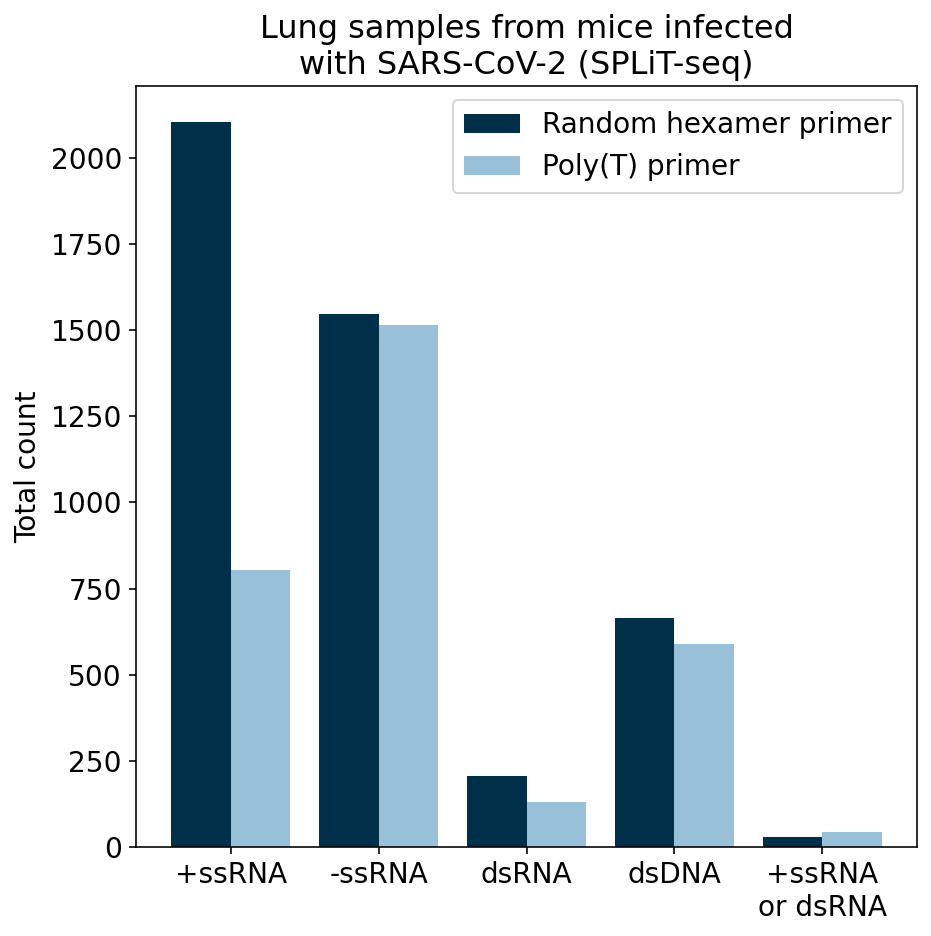

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))

fontsize = 14
width = 0.4
colors = ["#003049", "#98c1d9"]

x = np.arange(len(vtypes))
ax.bar(x-width/2, r_counts, width=width, color=colors[0], label="Random hexamer primer")
ax.bar(x+width/2, t_counts, width=width, color=colors[1], label="Poly(T) primer")

ax.legend(fontsize=fontsize)

ax.set_ylabel("Total count", fontsize=fontsize)

ax.set_title("Lung samples from mice infected\nwith SARS-CoV-2 (SPLiT-seq)", fontsize=fontsize+2)

ax.set_xticks(x, vlabels)
ax.tick_params(axis='both', labelsize=fontsize)

# fig.savefig("figures/4_random_vs_polyT_primer.png", dpi=300, bbox_inches="tight")

fig.show()

### Exclude virus counts less than X per cell
It looks like there was some contamination between wells, removing low counts might clean this up.

In [35]:
# Minimum count
threshold_per_cell = 1

In [36]:
vtypes = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA or dsRNA']
vlabels = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA\nor dsRNA']

t_counts = []
r_counts = []
for vt in vtypes:
    target_ids = id2tax_df[id2tax_df["virus_type"] == vt]["Label"].values
    
    # Get counts for poly T primer
    tc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    tc = tc[tc > threshold_per_cell]
    t_counts.append(np.sum(tc))
    
    # Get counts for random primers
    rc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    rc = rc[rc > threshold_per_cell]
    r_counts.append(np.sum(rc))

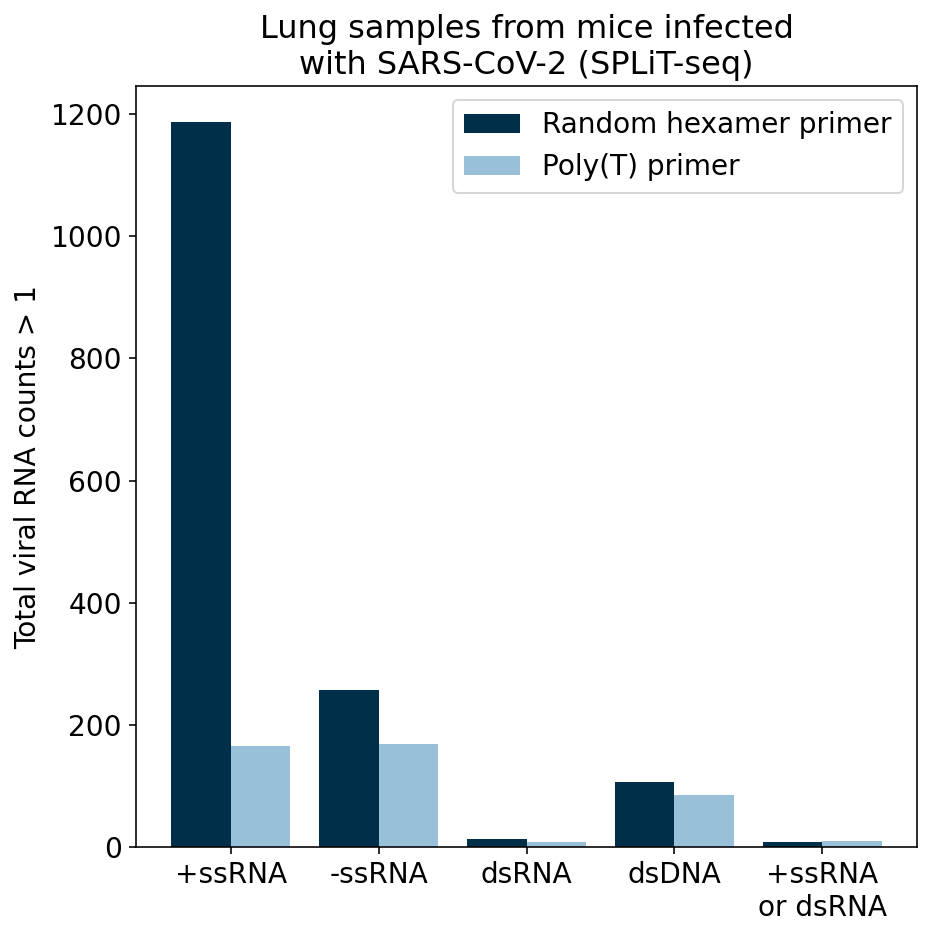

In [37]:
fig, ax = plt.subplots(figsize=(7, 7))

fontsize = 14
width = 0.4
colors = ["#003049", "#98c1d9"]

x = np.arange(len(vtypes))
ax.bar(x-width/2, r_counts, width=width, color=colors[0], label="Random hexamer primer")
ax.bar(x+width/2, t_counts, width=width, color=colors[1], label="Poly(T) primer")

ax.legend(fontsize=fontsize)

ax.set_ylabel("Total viral RNA counts > 1", fontsize=fontsize)

ax.set_title("Lung samples from mice infected\nwith SARS-CoV-2 (SPLiT-seq)", fontsize=fontsize+2)

ax.set_xticks(x, vlabels)
ax.tick_params(axis='both', labelsize=fontsize)

fig.savefig("figures/4_random_vs_polyT_primer.png", dpi=300, bbox_inches="tight")

fig.show()

### Exclude virus counts less than X per cell
It looks like there was some contamination between wells, removing low counts might clean this up.

In [46]:
# Minimum count
threshold_per_cell = 0

In [47]:
vtypes = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA or dsRNA']
vlabels = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA\nor dsRNA']

t_counts = []
r_counts = []
for vt in vtypes:
    target_ids = id2tax_df[id2tax_df["virus_type"] == vt]["Label"].values
    
    # Get counts for poly T primer
    tc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    tc = tc[tc > threshold_per_cell]
    
    # Get counts for random primers
    rc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    rc = rc[rc > threshold_per_cell]
    
    t_counts.append(np.sum(tc) / (np.sum(tc) + np.sum(rc)))
    r_counts.append(np.sum(rc) / (np.sum(tc) + np.sum(rc)))

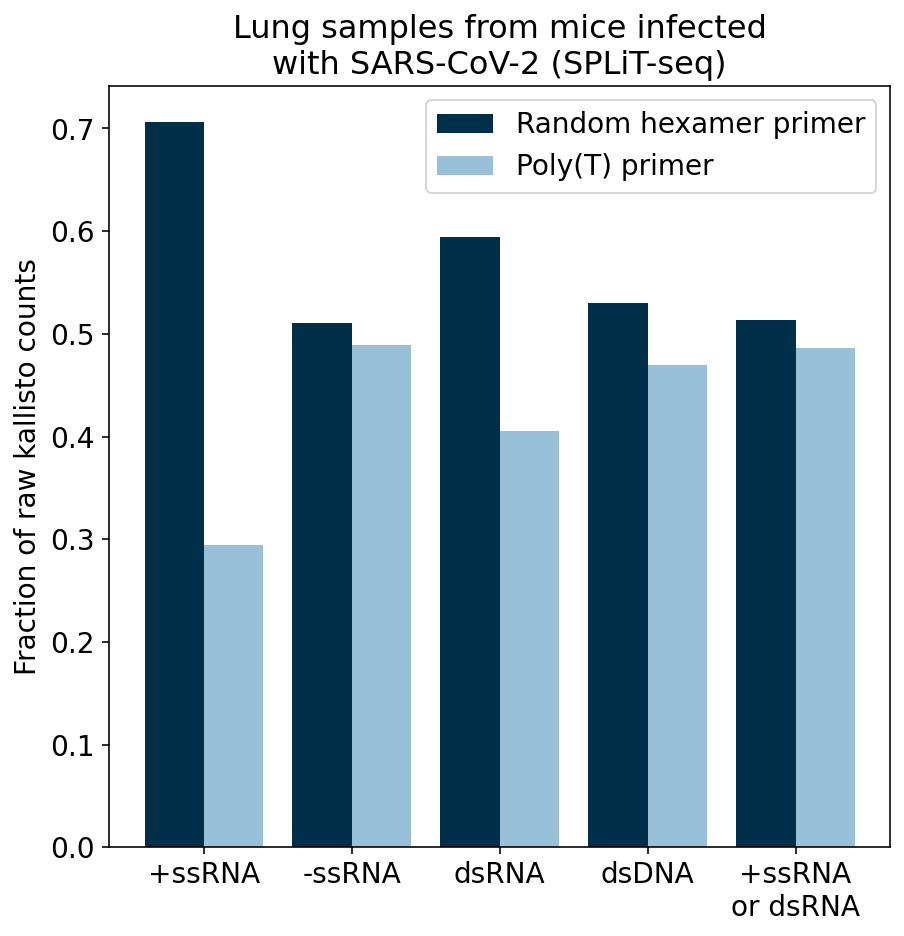

In [48]:
fig, ax = plt.subplots(figsize=(7, 7))

fontsize = 14
width = 0.4
colors = ["#003049", "#98c1d9"]

x = np.arange(len(vtypes))
ax.bar(x-width/2, r_counts, width=width, color=colors[0], label="Random hexamer primer")
ax.bar(x+width/2, t_counts, width=width, color=colors[1], label="Poly(T) primer")

ax.legend(fontsize=fontsize)

ax.set_ylabel("Fraction of raw kallisto counts", fontsize=fontsize)

ax.set_title("Lung samples from mice infected\nwith SARS-CoV-2 (SPLiT-seq)", fontsize=fontsize+2)

ax.set_xticks(x, vlabels)
ax.tick_params(axis='both', labelsize=fontsize)

fig.savefig("figures/4_random_vs_polyT_primer.png", dpi=300, bbox_inches="tight")

fig.show()

### Plot +ssRNA viruses with known life cycle

In [49]:
# Minimum count
threshold_per_cell = 0

In [50]:
id2tax_df

,Label,phylum,class,order,family,genus,species,virus_type
0,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
2,u100,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus,+ssRNA
3,u1000,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Henipavirus,Hendra henipavirus,-ssRNA
4,u10000,Pisuviricota,Pisoniviricetes,Picornavirales,Caliciviridae,Norovirus,Norwalk virus,+ssRNA
...,...,...,...,...,...,...,...,...
296556,u99995,.,.,.,.,.,.,unknown
296557,u99996,Lenarviricota,Howeltoviricetes,Cryppavirales,Mitoviridae,.,.,+ssRNA
296558,u99997,.,.,.,.,.,.,unknown
296559,u99998,.,.,.,.,.,.,unknown


In [51]:
species = [
    "Severe acute respiratory syndrome-related coronavirus",
    "Bubaline alphaherpesvirus 1",
    "Murid betaherpesvirus 1"
]

labels = [
    "Severe acute respiratory\nsyndrome-related\ncoronavirus",
    "Bubaline\nalphaherpesvirus 1",
    "Murid\nbetaherpesvirus 1"
]

t_counts_sars = []
r_counts_sars = []
total_count = []
for sp in species:
    target_ids = id2tax_df[id2tax_df["species"] == sp]["Label"].values

    # Get counts for poly T primer
    tc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    tc = tc[tc > threshold_per_cell]
    # t_counts_sars.append(np.sum(tc) / t_total)

    # Get counts for random primers
    rc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    rc = rc[rc > threshold_per_cell]
    # r_counts_sars.append(np.sum(rc) / r_total)
    
    t_counts_sars.append(np.sum(tc) / (np.sum(tc) + np.sum(rc)))
    r_counts_sars.append(np.sum(rc) / (np.sum(tc) + np.sum(rc)))
    
    total_count.append(np.sum(tc) + np.sum(rc))

In [52]:
t_total = palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), :].X.sum()
r_total = palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), :].X.sum()
t_total

8261.0

In [53]:
r_total

10995.0

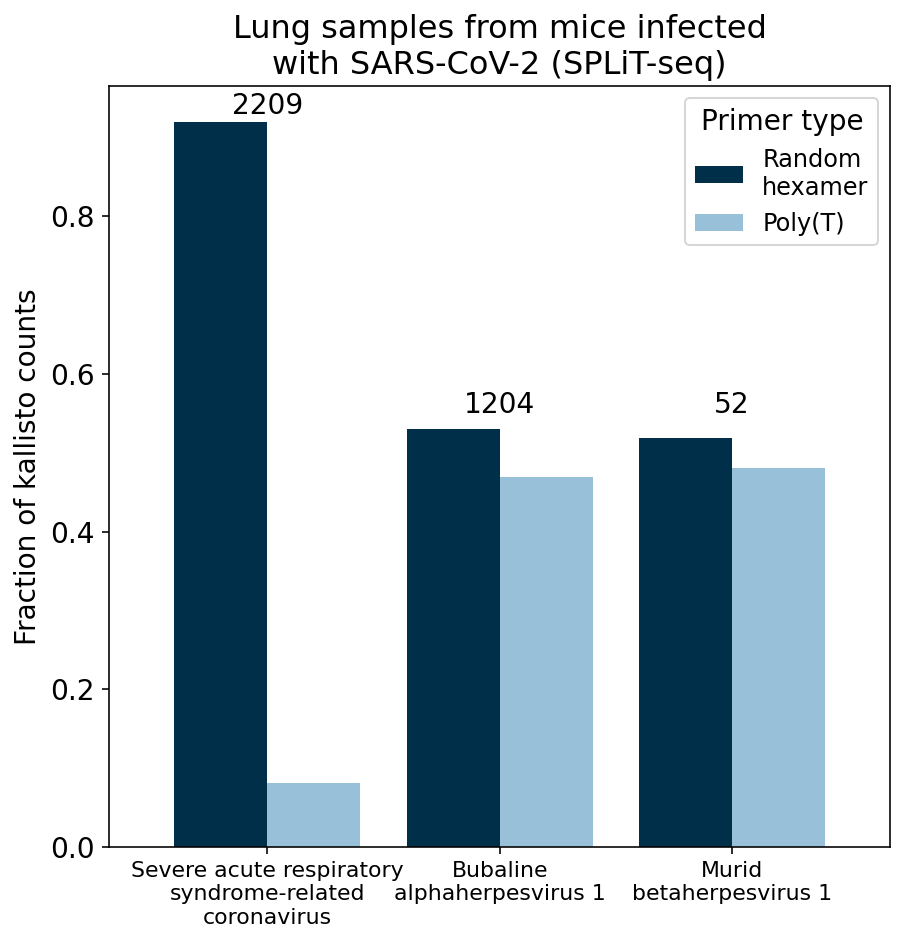

In [54]:
fig, ax = plt.subplots(figsize=(7, 7))

fontsize = 14
width = 0.4
colors = ["#003049", "#98c1d9"]

x = np.arange(len(species))
ax.bar(x-width/2, r_counts_sars, width=width, color=colors[0], label="Random\nhexamer")
ax.bar(x+width/2, t_counts_sars, width=width, color=colors[1], label="Poly(T)")

ax.legend(title="Primer type", fontsize=fontsize-2, title_fontsize=fontsize)

ax.set_ylabel("Fraction of kallisto counts", fontsize=fontsize)

ax.set_title("Lung samples from mice infected\nwith SARS-CoV-2 (SPLiT-seq)", fontsize=fontsize+2)

# Add total count above bar plots
pos = [0.93, 0.55, 0.55]
for i, tc in enumerate(total_count):
    ax.text(i, pos[i], int(tc), fontsize=fontsize, ha="center")

ax.tick_params(axis='y', labelsize=fontsize)
ax.set_xticks(x, labels, fontsize=fontsize-3)
ax.set_xmargin(0.1)

fig.savefig("figures/4_random_vs_polyT_primer_sarscov2.png", dpi=300, bbox_inches="tight")

fig.show()

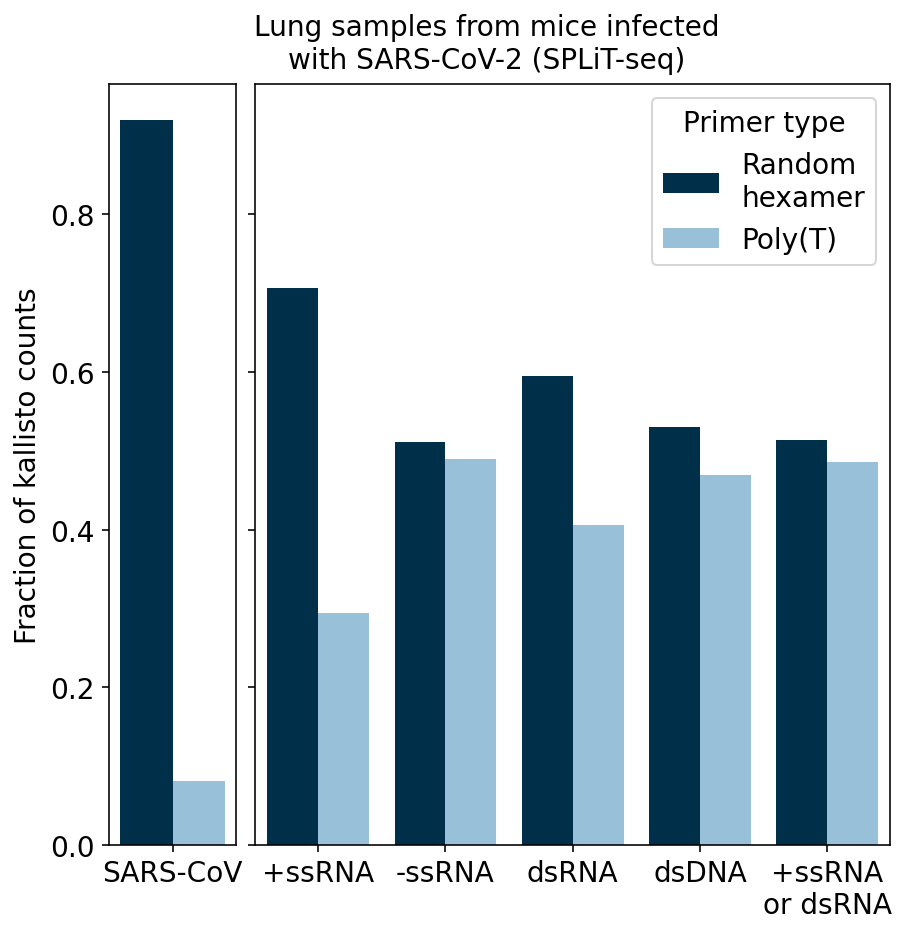

In [86]:
fig, axs = plt.subplots(figsize=(7, 7), ncols=2, sharey=True, gridspec_kw={'width_ratios': [1, 5], 'wspace': 0.05})

fontsize = 14
width = 0.4
colors = ["#003049", "#98c1d9"]

# Plot SARS-CoV2
ax = axs[0]
ax.bar(0-width/2, r_counts_sars[0], width=width, color=colors[0])
ax.bar(0+width/2, t_counts_sars[0], width=width, color=colors[1])
ax.set_xticks([0], ["SARS-CoV"], fontsize=fontsize)

# ax.set_xlabel("Known viral infection", fontsize=fontsize)
ax.set_ylabel("Fraction of kallisto counts", fontsize=fontsize)
ax.set_xmargin(0.1)

# Plot general strandedness
ax = axs[1]
x = np.arange(len(vtypes))
ax.bar(x-width/2, r_counts, width=width, color=colors[0], label="Random\nhexamer")
ax.bar(x+width/2, t_counts, width=width, color=colors[1], label="Poly(T)")

ax.legend(title="Primer type", fontsize=fontsize, title_fontsize=fontsize)
ax.set_xticks(np.arange(len(vlabels)), vlabels, fontsize=fontsize)
ax.set_xmargin(0.02)

# ax.set_xlabel("Strandedness", fontsize=fontsize)

# # Add total count above bar plots
# pos = [0.93, 0.55, 0.55]
# for i, tc in enumerate(total_count):
#     ax.text(i, pos[i], int(tc), fontsize=fontsize, ha="center")

for ax in axs:
    ax.tick_params(axis='y', labelsize=fontsize)

fig.suptitle("Lung samples from mice infected\nwith SARS-CoV-2 (SPLiT-seq)", fontsize=fontsize, y=0.95)

fig.savefig("figures/4_random_vs_polyT_final.png", dpi=300, bbox_inches="tight")

fig.show()

### Correct count to number of cells:

In [306]:
vtypes = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA or dsRNA']
vlabels = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA\nor dsRNA']

tcs = []
rcs = []
for vt in vtypes:
    target_ids = id2tax_df[id2tax_df["virus_type"] == vt]["Label"].values
    
    # Get counts for poly T primer
    tc = palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense()
    tcs.append(np.sum(tc) / len(tc))
    
    # Get counts for random primers
    rc = palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense()
    rcs.append(np.sum(rc) / len(rc))

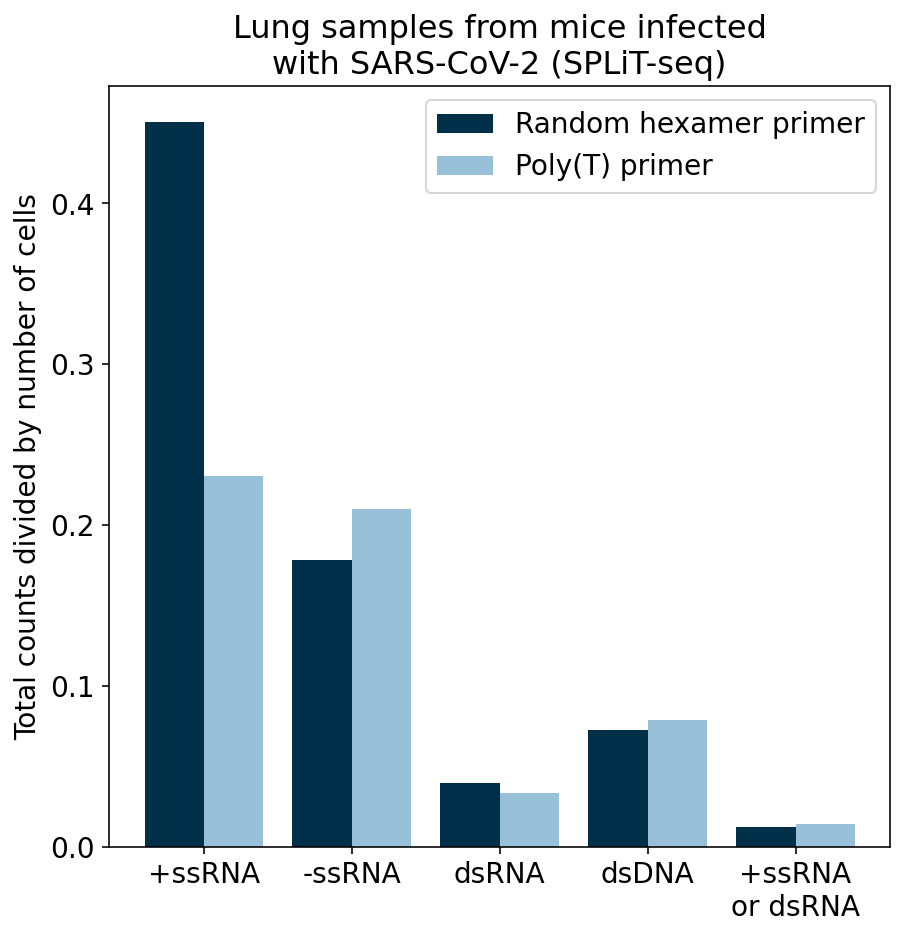

In [307]:
fig, ax = plt.subplots(figsize=(7, 7))

fontsize = 14
width = 0.4
colors = ["#003049", "#98c1d9"]

x = np.arange(len(vtypes))
ax.bar(x-width/2, rcs, width=width, color=colors[0], label="Random hexamer primer")
ax.bar(x+width/2, tcs, width=width, color=colors[1], label="Poly(T) primer")

ax.legend(fontsize=fontsize)

ax.set_ylabel("Total counts divided by number of cells", fontsize=fontsize)

ax.set_title("Lung samples from mice infected\nwith SARS-CoV-2 (SPLiT-seq)", fontsize=fontsize+2)

ax.set_xticks(x, vlabels)
ax.tick_params(axis='both', labelsize=fontsize)

# ax.set_yscale("log")

# fig.savefig("figures/4_random_vs_polyT_primer.png", dpi=300, bbox_inches="tight")

fig.show()

In [308]:
# # Plot fractions of counts per primer type
# vtypes = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA or dsRNA']
# vlabels = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA\nor dsRNA']

# t_fracs = []
# r_fracs = []
# for vt in vtypes:
#     target_ids = id2tax_df[id2tax_df["virus_type"] == vt]["Label"].values
    
#     # Get counts for poly T primer
#     tc = palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.sum()
    
#     # Get counts for random primers
#     rc = palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.sum()
    
#     total = tc + rc
#     t_fracs.append(tc / total)
#     r_fracs.append(rc / total)

In [309]:
# fig, ax = plt.subplots(figsize=(7, 7))

# fontsize = 14
# width = 0.75
# colors = ["#003049", "#98c1d9"]

# x = np.arange(len(vtypes))
# ax.bar(x, r_fracs, width=width, color=colors[0], label="Random primer")
# ax.bar(x, t_fracs, bottom=r_fracs, width=width, color=colors[1], label="Poly(T) primer")

# ax.legend(fontsize=fontsize)

# ax.set_ylabel("Total count", fontsize=fontsize)

# ax.set_title("Lung samples from mice infected\nwith SARS-CoV-2 (SPLiT-seq)", fontsize=fontsize+2)

# ax.set_xticks(x, vlabels)
# ax.tick_params(axis='both', labelsize=fontsize)

# # fig.savefig("figures/4_random_vs_polyT_primer.png", dpi=300, bbox_inches="tight")

# fig.show()